In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener, fftconvolve
from scipy.linalg import toeplitz,  cho_factor, cho_solve, pinvh
from sklearn.metrics import mean_squared_error
from IPython.display import Audio

import scipy.io.wavfile as wav


In [12]:
path = librosa.example("nutcracker")
Audio(path)

In [13]:
sample, sampling_rate = librosa.load(path)

start = 30
end = 36
sample = sample[int(sampling_rate * start):int(sampling_rate * end)]

In [14]:
timer = np.array(range(sample.shape[0])) / sampling_rate

Audio(sample, rate=sampling_rate)

In [15]:
noise = np.random.normal(0, 0.03, sample.shape[0])


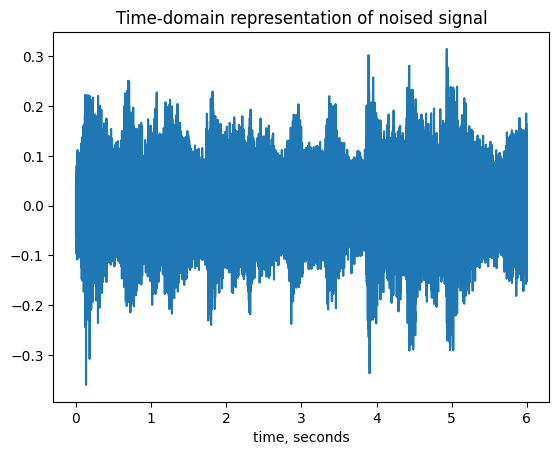

In [16]:
signal = sample + noise

plt.plot(timer, signal)
plt.title('Time-domain representation of noised signal')
plt.xlabel('time, seconds')
plt.show()

Audio(signal, rate=sampling_rate)

In [17]:
lib_wiener_filtered = wiener(signal, noise=np.var(noise), mysize=40)


Audio(lib_wiener_filtered, rate=sampling_rate)

In [38]:
def orthogonal_diag_inverse(matrix, vec): #works much slower than inverse
    ev, evc = np.linalg.eigh(matrix)
    D_inv = np.diag(ev**-1)
    return (evc@D_inv@evc.T)@vec

def cholesky(matrix, vec):
    c, low = cho_factor(matrix)
    return cho_solve((c, low), vec)

def svd_inverse(matrix, vec):
    Q, D, Q_T = np.linalg.svd(matrix)
    D_inv = np.diag(D**-1)
    return (Q@D_inv@Q_T)@vec

def straightforward_inverse(matrix, vec):
    return np.linalg.inv(matrix)@vec

def pseudo_inverse(matrix, vec):
    return pinvh(matrix)@vec


def optimal_filter(samples, noise, method):
    correlation = fftconvolve(samples, samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, rxx)
    rvv = fftconvolve(noise, noise[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv

    filter = method(autocorrelation_matrix, cross_correlation_estimate)
    
    return filter


def wiener_filter(last_samples, noise_sample, method=cholesky):
    filter = optimal_filter(last_samples, noise_sample, method)
    return filter.T@last_samples



In [39]:
def LMS_iterative(last_samples, noise_sample):
    speech_estimate = np.var(last_samples) + np.var(noise_sample)
    weights = np.zeros(last_samples.size)
    correlation = fftconvolve(last_samples, last_samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, rxx)
    rvv = fftconvolve(noise_sample, noise_sample[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv
    vals =np.linalg.eigvalsh(autocorrelation_matrix)
    mu = 2/(np.amin(vals) + np.amax(vals))
    sample_est= last_samples[-1] - noise_sample[-1]
    error = sample_est -  weights.T@last_samples
    mse =  speech_estimate - (2*cross_correlation_estimate + weights@autocorrelation_matrix)@weights
    prev_mse = mse
    it = 0
    max_it = 10
    while mse<=prev_mse and it < max_it:
        prev_mse = mse
        it+=1
        error = sample_est - weights.T@last_samples
        weights = weights + (2*mu*error)*last_samples
        mse = speech_estimate - (2*(cross_correlation_estimate) + weights@autocorrelation_matrix)@weights
    return weights.T@last_samples

In [45]:
filtered_us = []
windowsize = 40
methods=[pseudo_inverse, cholesky, orthogonal_diag_inverse, svd_inverse, straightforward_inverse]

for ind, method in enumerate(methods):
    current_filter = np.zeros(signal.size)
    print(ind)
    for i in range(1, signal.size):
        current_filter[i] = wiener_filter(signal[max(0, i-windowsize):i][::-1], noise[max(0, i-windowsize):i:][::-1], method=method)
    filtered_us.append(current_filter)
filtered_lms = np.zeros(signal.size)
for i in range(windowsize, signal.size):
    print(i)
    filtered_lms[i] = LMS_iterative(signal[max(0, i-windowsize):i],
                                    noise[max(0, i-windowsize):i])
print(5)
filtered_us.append(lib_wiener_filtered)
filtered_us.append(filtered_lms)
filtered_us.append(sample)


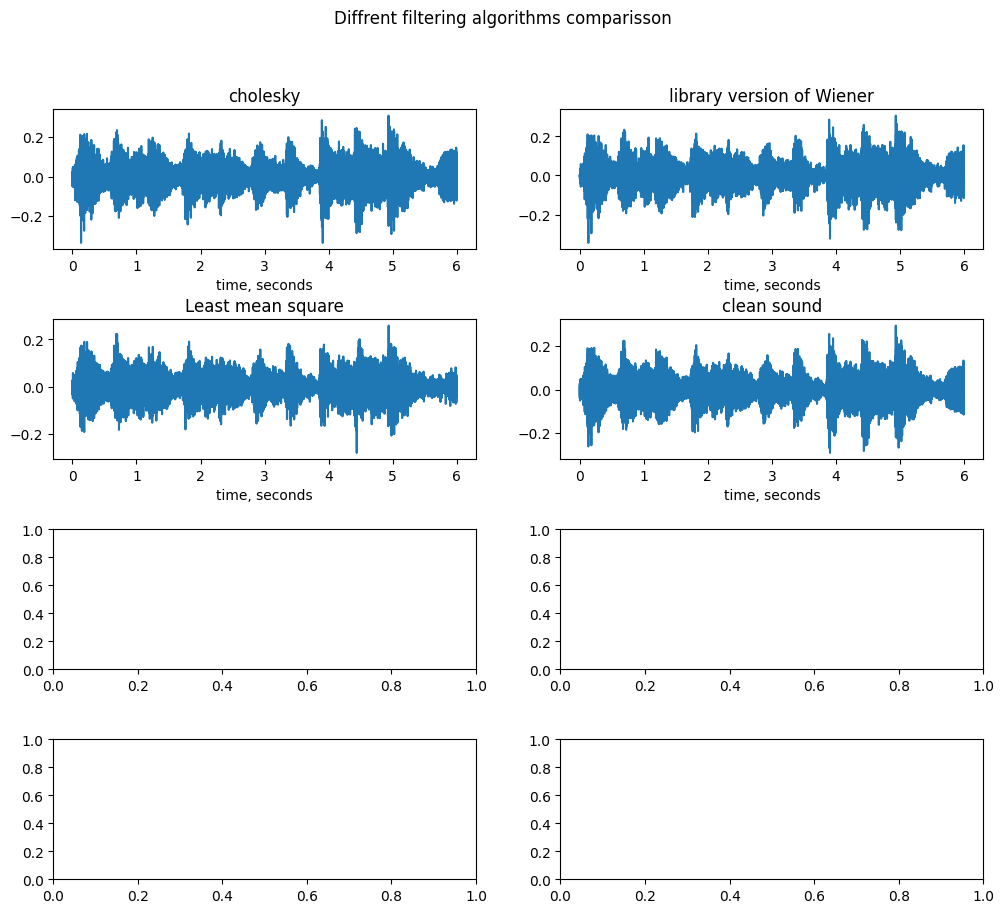

In [57]:
filternames = ["cholesky", "library version of Wiener",
                 "Least mean square","clean sound"]
i = 0
fix, axs = plt.subplots(nrows=4, ncols=2, figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
for filter, ax in zip(filtered_us, axs.ravel()):
    ax.plot(timer, filter)
    ax.set_title(filternames[i])
    ax.set_xlabel("time, seconds")
    i+=1

fix.suptitle("Diffrent filtering algorithms comparisson")
plt.show()



In [49]:
print("Mean Square error:")
print(f"Base MSE: {mean_squared_error(sample, signal)}")
for ind, name in enumerate(filternames):
    print(f"{name}: ", mean_squared_error(sample, filtered_us[ind]))


Mean Square error:
Base MSE: 0.0008995710545110286
cholesky:  0.00023250252949680246
library version of Wiener:  0.0004799403535663964
Least mean square:  0.0035014212511002714
clean sound:  0.0


In [50]:
basic_snr = np.var(signal)/np.var(noise)
print(f"SNR of the base sound: {basic_snr}")
for ind, samples in enumerate(filtered_us):
    removed = noise - (signal-samples)
    cur_snr = np.var(samples)/np.var(removed)
    print(f"SNR of {filternames[ind]} is: {cur_snr}")


SNR of the base sound: 3.860589117614317
SNR of cholesky is: 12.145964511204705
SNR of library version of Wiener is: 4.495734100837471
SNR of Least mean square is: 0.3515294201778915
SNR of clean sound is: 3.1296212296397388e+32


In [51]:
print("clean signal")
Audio(sample, rate=sampling_rate)

clean signal


In [52]:
print("noise signal")
Audio(signal, rate=sampling_rate)

noise signal


In [53]:
print("our wiener")
Audio(filtered_us[0], rate=sampling_rate)

our wiener


In [55]:
print("our lms")
Audio(filtered_lms, rate=sampling_rate)

our lms


In [56]:
print("library wiener")
Audio(lib_wiener_filtered, rate=sampling_rate)

library wiener
